In [2]:
from load_results import load_result_dataset
import pandas as pd
# import omegaconf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pn1 = 'full_fine_tuning_50epochs_edge_paper_final2'
pn2 = 'full_fine_tuning_50epochs_paper_final2'
final_data_50= load_result_dataset(pn1, pn2)
final_data_50 = [{**d, 'ft_strategy': 'FFT (50 epochs)'} for d in final_data_50]

pn1 = 'full_fine_tuning_5epochs_edge_article1'
pn2 = 'full_fine_tuning_5epochs_article1'
final_data_5 = load_result_dataset(pn1, pn2)
final_data_5 = [{**d, 'ft_strategy': 'FFT (5 epochs)'} for d in final_data_5]

pn1 = 'linearprobe_50epochs_edge_paper_final2'
pn2 = 'linearprobe_50epochs_paper_final2'
final_data_LP = load_result_dataset(pn1, pn2)
final_data_LP = [{**d, 'ft_strategy': 'LP (50 epochs)'} for d in final_data_LP]


combined = final_data_50 + final_data_5

../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion_aesthetic-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion2B-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/deit_small_patch16_224.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_resnet50_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/vit_small_patch16_224.augreg_in21k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/convnext_base.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/resnet50.a1_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_vit_base_patch16_224_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_

In [24]:
from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group

grouped_df = process_grouped_df(final_data_50,   )
grouped_df = process_rankings(grouped_df)
grouped_df = grouped_df[ ('TOTAL', )].reset_index()
grouped_df = grouped_df 
# grouped_df[ grouped_df.pre_training_strategy == 'supervised (robust)' ]

grouped_df.to_csv("./compute_vit.csv")


# Filter relevant architecture categories
keywords = ['eva02', 'swin', 'vit', 'deit']

# Extract matching rows
grouped_df = grouped_df[grouped_df['backbone'].str.contains('|'.join(keywords), case=False, na=False)]

# Assign category labels based on keyword
def assign_category(backbone):
    for key in keywords:
        if key in backbone.lower():
            return key
    return 'other'

grouped_df['category'] = grouped_df['backbone'].apply(assign_category)

# Merge 'vit' and 'deit' into a single category 'vit+deit'
grouped_df['category'] = grouped_df['category'].replace({'vit': 'vit+deit', 'deit': 'vit+deit'})

# Filter only for 'medium' and 'large' model sizes
grouped_df = grouped_df[grouped_df['model_size'].isin(['medium', 'large'])]

# Recompute mean Borda score per updated category
mean_borda_filtered = grouped_df.groupby('category')['borda'].mean().sort_values(ascending=False)

mean_borda_filtered

Percentage of NaN values: 0.01%


category
swin        1479.250000
eva02       1212.500000
vit+deit     916.153846
Name: borda, dtype: float64

In [13]:
from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group

grouped_df = process_grouped_df(combined,   )
grouped_df = process_rankings(grouped_df)
grouped_df[ ('TOTAL', )].reset_index()
grouped_df.to_csv("returns.csv")

grouped_df = grouped_df[('TOTAL',)].reset_index()
grouped_df
# # Pivot to get one row per backbone, with separate columns for 5 and 50 epochs
pivot = grouped_df.pivot_table(index=['backbone_name','model_size','model_type', 'pre_training_strategy', 'loss_function' ], columns='ft_strategy', values='score_sum', aggfunc='mean')

# # Compute returns as improvement from 5 to 50 epochs
pivot['returns'] = (pivot['FFT (50 epochs)'] - pivot['FFT (5 epochs)']) / pivot['FFT (5 epochs)']
pivot['returns2'] = (pivot['FFT (50 epochs)'] - pivot['FFT (5 epochs)']) / ( (pivot['FFT (50 epochs)'] + pivot['FFT (5 epochs)'])/2 )
pivot['returns3'] =  pivot['FFT (5 epochs)'] - pivot['FFT (50 epochs)'] 
# pivot = pivot.reset_index()

pivot = pivot.reset_index()
# pivot[ pivot['returns3']<0 ]


Percentage of NaN values: 0.09%


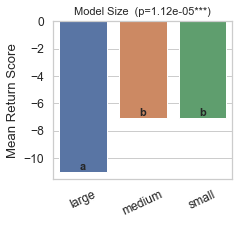

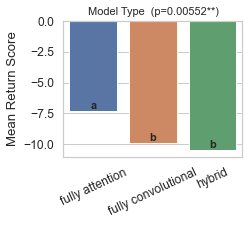

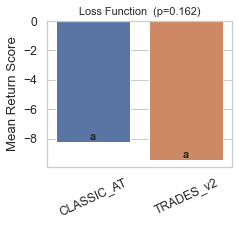

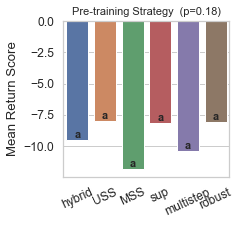

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from statsmodels.stats.multicomp import MultiComparison
import inspect

# Load the dataset again after reset
# df = pd.read_csv("/mnt/data/fft50_anova.csv")

target = 'returns3'

# Helper functions
xtick_label_map = {
    "hybrid": "hybrid",
    "self-supervised": "USS",
    "self-supervised (multimodal)": "MSS",
    "supervised": "sup",
    "supervised (robust)": "robust",
    "supervised (multistep)": "multistep",
}

def anova_stars(p):
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < .05 else '†' if p < .1 else ''

def get_tukey_letters(df, group_col, value_col, alpha=0.05):
    mc   = MultiComparison(df[value_col], df[group_col])
    res  = mc.tukeyhsd(alpha=alpha)
    comp = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])
    comp['reject'] = comp['reject'].astype(bool)

    groups   = list(mc.groupsunique)
    letters  = {g: '' for g in groups}
    remaining = set(groups)
    current   = 'a'

    while remaining:
        anchor  = sorted(remaining)[0]
        cluster = {anchor}
        for g in sorted(remaining):
            sig = comp.loc[
                ((comp.group1 == g) & (comp.group2.isin(cluster))) |
                ((comp.group2 == g) & (comp.group1.isin(cluster))), 'reject'
            ].any()
            if not sig:
                cluster.add(g)
        for g in cluster:
            letters[g] += current
        remaining -= cluster
        current = chr(ord(current) + 1)
    return letters

# Compute Welch's ANOVA p-values
welch_pvals = {}
for factor in ['model_size', 'model_type', 'loss_function', 'pre_training_strategy']:
    df_filtered = pivot[[factor, target]].dropna()
    groups = [group[target].values for name, group in df_filtered.groupby(factor)]
    _, pval = stats.f_oneway(*groups)
    welch_pvals[factor] = pval

# Plot configuration
sns.set(style="whitegrid", font_scale=1.1)
save_dir = "paper_figures"
os.makedirs(save_dir, exist_ok=True)
single_figsize = (3.2, 3.0)

titles = {
    'model_size': 'Model Size',
    'model_type': 'Model Type',
    'loss_function': 'Loss Function',
    'pre_training_strategy': 'Pre-training Strategy'
}

# Plot for each factor using Welch's ANOVA p-value
for factor in titles:
    order   = sorted(pivot[factor].dropna().unique())
    letters = get_tukey_letters(pivot, factor, target, alpha=0.1)

    fig, ax = plt.subplots(figsize=single_figsize)

    kwargs = dict(
        x=factor, y=target, data=pivot, order=order,
        estimator=np.mean, ci=None, ax=ax
    )
    if 'errorbar' in inspect.signature(sns.barplot).parameters:
        kwargs['errorbar'] = None
    sns.barplot(**kwargs)

    ax.set_ylabel("Mean Return Score")
    ax.set_xlabel("")
    ax.tick_params(axis='x',  rotation=25)
    if set(order).issubset(xtick_label_map.keys()):
        ax.set_xticklabels([xtick_label_map[l] for l in order])

    for bar, lvl in zip(ax.containers[0], order):
        ltr = letters.get(lvl, '')
        if ltr:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    ltr, ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    # Use Welch's p-value
    p = welch_pvals[factor]
    ax.set_title(f"{titles[factor]}  (p={p:.3g}{anova_stars(p)})", fontsize=11)

    fname = f"{save_dir}/returns_{factor}.png"
    plt.tight_layout(pad=0.2)
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    # plt.close(fig)
    plt.show()


In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Relevant variable pairs for interaction
interaction_pairs = [
    ("model_size", "model_type"),
    ("loss_function", "model_type"),
    ("loss_function", "model_size"),
    ("pre_training_strategy", "model_type"),
    ("pre_training_strategy", "model_size"),
    ("pre_training_strategy", "loss_function"),
]

# Container to store results
results = {}

for var1, var2 in interaction_pairs:
    print(var1, var2)
    formula = f"{target} ~ C({var1}) / C({var2})"
    print(formula)
    model = smf.ols(formula, data=pivot).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Compute group means for plotting
    group_means = pivot.groupby([var1, var2])[target].mean().reset_index()

    # Store in results dictionary
    key = f"{var1}/{var2}"
    results[key] = {
        "anova": anova_table,
        "means": group_means,
    }

results


model_size model_type
returns3 ~ C(model_size) / C(model_type)
loss_function model_type
returns3 ~ C(loss_function) / C(model_type)
loss_function model_size
returns3 ~ C(loss_function) / C(model_size)
pre_training_strategy model_type
returns3 ~ C(pre_training_strategy) / C(model_type)
pre_training_strategy model_size
returns3 ~ C(pre_training_strategy) / C(model_size)
pre_training_strategy loss_function
returns3 ~ C(pre_training_strategy) / C(loss_function)


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints

{'model_size/model_type': {'anova':                                  sum_sq    df          F        PR(>F)
  C(model_size)                302.822975   2.0  18.018220  4.691347e-07
  C(model_size):C(model_type)  282.532794   6.0   5.603646  8.364621e-05
  Residual                     596.630275  71.0        NaN           NaN,
  'means':   model_size           model_type   returns3
  0      large      fully attention  -8.682418
  1      large  fully convolutional -12.789633
  2      large               hybrid -14.939067
  3     medium      fully attention  -5.750835
  4     medium  fully convolutional  -8.575209
  5     medium               hybrid  -8.519095
  6      small      fully attention  -7.793738
  7      small  fully convolutional  -5.698542
  8      small               hybrid  -8.181167},
 'loss_function/model_type': {'anova':                                     sum_sq    df         F    PR(>F)
  C(loss_function)                 29.396004   1.0  2.197822  0.142452
  C(loss_func

model_size model_type


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


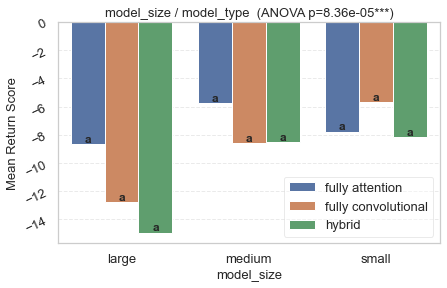

loss_function model_type


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


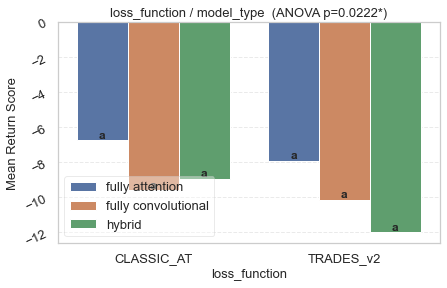

loss_function model_size


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


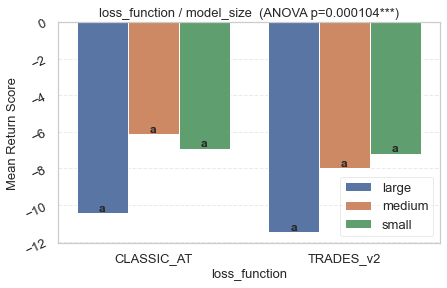

pre_training_strategy model_type


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


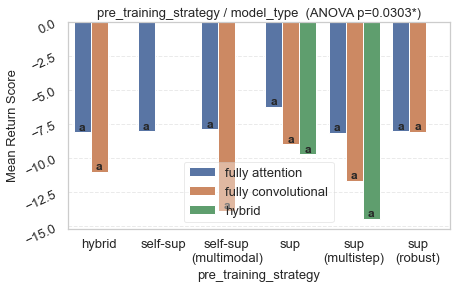

pre_training_strategy model_size


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


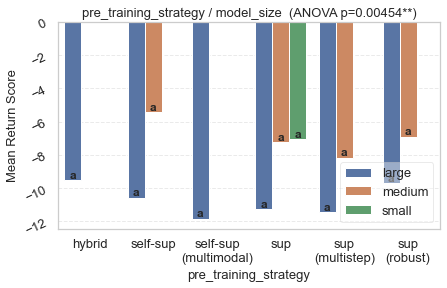

pre_training_strategy loss_function


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


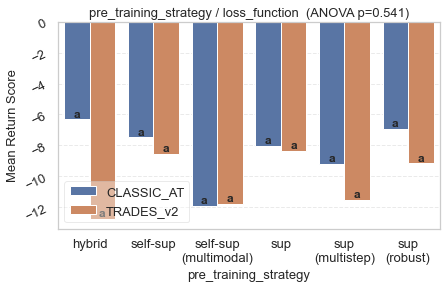

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import pandas as pd

# Custom label mapping (applies only when var1 is one of these)
# Custom label mapping (applies only when var1 is one of these)
xtick_label_map = {
    "hybrid": "hybrid",
    "self-supervised": "self-sup",
    "self-supervised (multimodal)": "self-sup\n(multimodal)",
    "supervised": "sup",
    "supervised (robust)": "sup\n(robust)",
    "supervised (multistep)": "sup\n(multistep)",
}


# ── helpers ──────────────────────────────────────────────────────────────
def anova_stars(p):
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < .05 else '†' if p < .1 else ''

from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 13,             # base size for all text
    'axes.titlesize': 13,        # title
    'axes.labelsize': 13,        # axis labels
    'xtick.labelsize': 13,       # x-tick labels
    'ytick.labelsize': 13,       # y-tick labels
    'legend.fontsize': 13,       # legend
})


def get_tukey_letters(df, group_col, value_col, alpha=0.1):
    """
    Return dict {group_label: letter(s)} using Tukey HSD results.
    Same letter → groups NOT significantly different (α).
    """
    mc      = MultiComparison(df[value_col], df[group_col])
    result  = mc.tukeyhsd(alpha=alpha)

    # Convert summary to DataFrame
    comp = pd.DataFrame(result.summary().data[1:], columns=result.summary().data[0])
    comp['reject'] = comp['reject'].astype(bool)   # ensure Boolean

    groups = list(mc.groupsunique)
    letters = {g: '' for g in groups}
    current_letter = 'a'

    # Greedy algorithm to assign letters
    remaining = set(groups)
    while remaining:
        # Start a new group with the first remaining item
        g0 = sorted(remaining)[0]
        group_set = {g0}

        # Add any non‑significant partners to this letter group
        for g in sorted(remaining):
            # Is there any significant diff between g and something already in group_set?
            sig_any = comp.loc[
                ((comp['group1'] == g) & (comp['group2'].isin(group_set))) |
                ((comp['group2'] == g) & (comp['group1'].isin(group_set))), 'reject'
            ].any()
            if not sig_any:
                group_set.add(g)

        # assign current letter to everyone in this cluster
        for g in group_set:
            letters[g] += current_letter
        remaining -= group_set
        current_letter = chr(ord(current_letter) + 1)

    return letters


import matplotlib.pyplot as plt
import seaborn as sns

for key, res in results.items():
    if 'anova' not in res or 'means' not in res or '/' not in key:
        continue

    var1, var2   = key.split('/')
    pivot     = res['means'].copy()
    df_full      = pivot.copy()

    print(var1, var2)

    # build orders
    x_order   = sorted(pivot[var1].unique())
    hue_order = sorted(pivot[var2].unique())

    # interaction labels
    df_full['interaction']  = df_full[var1].astype(str) + ' | ' + df_full[var2].astype(str)
    pivot['interaction'] = pivot[var1].astype(str) + ' | ' + pivot[var2].astype(str)

    # Tukey letters
    letters = get_tukey_letters(df_full, 'interaction', target, alpha=0.1)
    pivot['letter'] = pivot['interaction'].map(letters)

    # ANOVA p‑value
    int_label = f'C({var1}):C({var2})'
    anova_p   = res['anova'].loc[int_label if int_label in res['anova'].index
                                 else res['anova'].index[-1], 'PR(>F)']
    

    # plot
    # plt.figure(figsize=(10, 6))
    plt.figure(figsize=(6.4, 4.2))  # clean, LaTeX-optimized

    ax = sns.barplot(data=pivot,
                     x=var1, y=target, hue=var2,
                     order=x_order, hue_order=hue_order)
    
    ax.tick_params(rotation=25)
    
    if set(x_order).issubset(xtick_label_map.keys()):
        new_labels = [xtick_label_map.get(l, l) for l in x_order]
        ax.set_xticklabels(new_labels)

    # annotate letters
    for c_idx, container in enumerate(ax.containers):
        hue_val = hue_order[c_idx]
        for b_idx, bar in enumerate(container):
            x_val  = x_order[b_idx]
            key_lbl = f"{x_val} | {hue_val}"
            letter  = letters.get(key_lbl, '')
            if letter:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height() + 0.01,
                        letter, ha='center', va='bottom',
                        fontsize=12, fontweight='bold')

    plt.title(f"{var1} / {var2}  "
              f"(ANOVA p={anova_p:.3g}{anova_stars(anova_p)})")
    plt.ylabel("Mean Return Score")

    # plt.xticks(rotation=45)
    plt.xticks(rotation=0)

    plt.grid(axis='y', linestyle='--', alpha=.4)
    plt.tight_layout()
    plt.legend(frameon=True, framealpha=0.4)  # lower alpha → more transparency

    plt.savefig(
        f"paper_figures/returns_interaction_{key.replace('/', '_')}.png",  # or .pdf, .svg, etc.
        dpi=300,          # high resolution
        bbox_inches='tight',  # remove extra whitespace
        pad_inches=0.05,       # minimal border around axes
        transparent=False      # or True if you want alpha background
    )

    plt.show()